In [7]:
!pip install -q torch torchvision tqdm einops
!pip install torch_ema
import math, os, random, time, csv, pickle
from pathlib import Path
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from einops import rearrange

In [3]:
# config
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)

cfg = {
    "image_size": 32,
    "patch_size": 4,          # not directly used now, but kept for reference
    "in_channels": 3,
    "num_classes": 100,

    # ViT size – smaller & scratch-friendly
    "emb_dim": 192,
    "num_heads": 6,
    "depth": 6,
    "mlp_ratio": 4.0,
    "drop": 0.1,
    "drop_path": 0.1,

    "batch_size": 128,
    "epochs": 200,
    "lr": 4e-4,
    "weight_decay": 0.05,
    "warmup_epochs": 5,
    "label_smoothing": 0.05,
    "ema_decay": 0.9999,
    "seed": 42,
}

# reproducibility
torch.manual_seed(cfg["seed"])
random.seed(cfg["seed"])


device: mps


In [4]:
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

# Less destructive, CIFAR-friendly pipeline
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=10),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, value='random'),
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root="data", train=True, download=True, transform=train_transform)
test_ds  = datasets.CIFAR100(root="data", train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=cfg["batch_size"], shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False,
                          num_workers=2, pin_memory=True)

steps_per_epoch = len(train_loader)
total_steps = cfg["epochs"] * steps_per_epoch
warmup_steps = cfg["warmup_epochs"] * steps_per_epoch

In [5]:
class ConvPatchEmbed(nn.Module):
    def __init__(self, img_size=32, in_chans=3, embed_dim=192):
        super().__init__()
        # 32x32 -> 32x32 -> 16x16 -> 16x16
        self.proj = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),  # 32 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, embed_dim, kernel_size=3, stride=1, padding=1, bias=False),  # stays 16x16
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
        )

        grid_size = (img_size // 2, img_size // 2)  # (16,16)
        self.grid_size = grid_size
        self.num_patches = grid_size[0] * grid_size[1]

    def forward(self, x):
        x = self.proj(x)         # (B, E, H=16, W=16)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, N=H*W, E)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # (B, N, 3C) -> (3, B, heads, N, head_dim)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

# Simple Stochastic Depth
class StochasticDepth(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = float(p)

    def forward(self, x):
        if not self.training or self.p == 0.0:
            return x
        keep_prob = 1.0 - self.p
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x / keep_prob * random_tensor

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = StochasticDepth(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio), drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class ViT(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        img_size = cfg["image_size"]

        self.patch_embed = ConvPatchEmbed(
            img_size=img_size,
            in_chans=cfg["in_channels"],
            embed_dim=cfg["emb_dim"]
        )
        n_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg["emb_dim"]))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + n_patches, cfg["emb_dim"]))
        self.pos_drop = nn.Dropout(p=cfg["drop"])

        # stochastic depth decay rule
        dpr = torch.linspace(0, cfg["drop_path"], cfg["depth"]).tolist()
        self.blocks = nn.ModuleList([
            Block(
                dim=cfg["emb_dim"],
                num_heads=cfg["num_heads"],
                mlp_ratio=cfg["mlp_ratio"],
                drop=cfg["drop"],
                drop_path=dpr[i]
            )
            for i in range(cfg["depth"])
        ])
        self.norm = nn.LayerNorm(cfg["emb_dim"])
        self.head = nn.Linear(cfg["emb_dim"], cfg["num_classes"])

        # init
        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)                   # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)     # (B, 1+N, E)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls = x[:, 0]
        out = self.head(cls)
        return out

In [8]:
model = ViT(cfg).to(device)

# optional EMA
try:
    from torch_ema import ExponentialMovingAverage
    ema = ExponentialMovingAverage(model.parameters(), decay=cfg["ema_decay"])
    use_ema = True
    print("Using EMA")
except ImportError:
    ema = None
    use_ema = False
    print("torch_ema not found, skipping EMA")

optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

def lr_lambda(global_step):
    if global_step < warmup_steps:
        return float(global_step) / float(max(1, warmup_steps))
    progress = float(global_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    # cosine from 1 -> 0
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg["label_smoothing"])

Using EMA


In [10]:
def train_one_epoch(model, loader, optimizer, scheduler, epoch, global_step):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    pbar = tqdm(loader, desc=f"Train Epoch {epoch}")
    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if use_ema:
            ema.update()

        scheduler.step()
        global_step += 1

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total,
                         lr=optimizer.param_groups[0]["lr"])

    return running_loss/total, 100.*correct/total, global_step

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    losses = 0.0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        losses += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
    return losses/total, 100.*correct/total

In [11]:
best_acc = 0.0
history = []
csv_file = "Revised_baseline_vit_cifar100_metrics.csv"

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "lr"])

global_step = 0

for epoch in range(cfg["epochs"]):
    train_loss, train_acc, global_step = train_one_epoch(
        model, train_loader, optimizer, scheduler, epoch, global_step
    )

    # if you want to eval EMA weights, you can swap here
    if use_ema:
        # evaluate with EMA-averaged parameters
        ema.store()
        ema.copy_to(model.parameters())
        val_loss, val_acc = evaluate(model, test_loader)
        ema.restore()
    else:
        val_loss, val_acc = evaluate(model, test_loader)

    lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch:03d}: "
          f"train_loss={train_loss:.4f} train_acc={train_acc:.2f}% | "
          f"val_loss={val_loss:.4f} val_acc={val_acc:.2f}% | lr={lr:.6f}")

    history.append((epoch, train_loss, train_acc, val_loss, val_acc, lr))
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, val_loss, val_acc, lr])

    if val_acc > best_acc:
        best_acc = val_acc
        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "best_acc": best_acc,
            "history": history,
        }
        torch.save(checkpoint, "Revised_best_ViT_CIFAR100_baseline_checkpoint.pth")
        print(f"Saved new best model: {best_acc:.2f}%")

print("Best test accuracy: %.2f%%" % best_acc)

with open("Revised_baseline_vit_cifar100_history.pkl", "wb") as f:
    pickle.dump(history, f)

print("Saved history to Revised_baseline_vit_cifar100_history.pkl &", csv_file)


Train Epoch 0:   0%|                                    | 0/391 [00:00<?, ?it/s]/Users/aumkeshchaudhary/anaconda3/envs/yolo/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Train Epoch 0: 100%|█| 391/391 [04:05<00:00,  1.60it/s, acc=3.27, loss=4.6, lr=8


Epoch 000: train_loss=4.6002 train_acc=3.27% | val_loss=4.0785 val_acc=9.11% | lr=0.000080
Saved new best model: 9.11%


Train Epoch 1: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=8.34, loss=4.09, lr=


Epoch 001: train_loss=4.0926 train_acc=8.34% | val_loss=3.7343 val_acc=14.83% | lr=0.000160
Saved new best model: 14.83%


Train Epoch 2: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=12.7, loss=3.84, lr=


Epoch 002: train_loss=3.8355 train_acc=12.67% | val_loss=3.4798 val_acc=19.60% | lr=0.000240
Saved new best model: 19.60%


Train Epoch 3: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=16.7, loss=3.6, lr=0


Epoch 003: train_loss=3.6043 train_acc=16.66% | val_loss=3.1985 val_acc=24.92% | lr=0.000320
Saved new best model: 24.92%


Train Epoch 4: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=20, loss=3.43, lr=0.


Epoch 004: train_loss=3.4281 train_acc=19.96% | val_loss=3.0208 val_acc=28.94% | lr=0.000400
Saved new best model: 28.94%


Train Epoch 5: 100%|█| 391/391 [04:08<00:00,  1.57it/s, acc=22.7, loss=3.29, lr=


Epoch 005: train_loss=3.2897 train_acc=22.72% | val_loss=2.8157 val_acc=33.55% | lr=0.000400
Saved new best model: 33.55%


Train Epoch 6: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=25.4, loss=3.16, lr=


Epoch 006: train_loss=3.1615 train_acc=25.38% | val_loss=2.6874 val_acc=35.89% | lr=0.000400
Saved new best model: 35.89%


Train Epoch 7: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=27.6, loss=3.05, lr=


Epoch 007: train_loss=3.0498 train_acc=27.59% | val_loss=2.5878 val_acc=37.91% | lr=0.000400
Saved new best model: 37.91%


Train Epoch 8: 100%|█| 391/391 [04:10<00:00,  1.56it/s, acc=30.1, loss=2.94, lr=


Epoch 008: train_loss=2.9427 train_acc=30.06% | val_loss=2.4683 val_acc=41.04% | lr=0.000400
Saved new best model: 41.04%


Train Epoch 9: 100%|█| 391/391 [04:08<00:00,  1.58it/s, acc=31.7, loss=2.87, lr=


Epoch 009: train_loss=2.8729 train_acc=31.74% | val_loss=2.4254 val_acc=41.91% | lr=0.000399
Saved new best model: 41.91%


Train Epoch 10: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=33.5, loss=2.79, lr


Epoch 010: train_loss=2.7928 train_acc=33.54% | val_loss=2.3479 val_acc=43.88% | lr=0.000399
Saved new best model: 43.88%


Train Epoch 11: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=35.1, loss=2.73, lr


Epoch 011: train_loss=2.7302 train_acc=35.07% | val_loss=2.2982 val_acc=44.81% | lr=0.000399
Saved new best model: 44.81%


Train Epoch 12: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=36.3, loss=2.66, lr


Epoch 012: train_loss=2.6649 train_acc=36.33% | val_loss=2.2319 val_acc=46.79% | lr=0.000398
Saved new best model: 46.79%


Train Epoch 13: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=38.2, loss=2.6, lr=


Epoch 013: train_loss=2.6024 train_acc=38.22% | val_loss=2.1711 val_acc=48.61% | lr=0.000398
Saved new best model: 48.61%


Train Epoch 14: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=39.2, loss=2.55, lr


Epoch 014: train_loss=2.5522 train_acc=39.23% | val_loss=2.1362 val_acc=49.38% | lr=0.000397
Saved new best model: 49.38%


Train Epoch 15: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=40.1, loss=2.52, lr


Epoch 015: train_loss=2.5170 train_acc=40.12% | val_loss=2.0792 val_acc=51.11% | lr=0.000397
Saved new best model: 51.11%


Train Epoch 16: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=41.4, loss=2.46, lr


Epoch 016: train_loss=2.4634 train_acc=41.35% | val_loss=2.0642 val_acc=51.24% | lr=0.000396
Saved new best model: 51.24%


Train Epoch 17: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=42.5, loss=2.41, lr


Epoch 017: train_loss=2.4145 train_acc=42.54% | val_loss=2.0800 val_acc=51.29% | lr=0.000396
Saved new best model: 51.29%


Train Epoch 18: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=43.7, loss=2.36, lr


Epoch 018: train_loss=2.3638 train_acc=43.71% | val_loss=1.9977 val_acc=53.17% | lr=0.000395
Saved new best model: 53.17%


Train Epoch 19: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=45.4, loss=2.31, lr


Epoch 019: train_loss=2.3137 train_acc=45.40% | val_loss=1.9771 val_acc=53.89% | lr=0.000394
Saved new best model: 53.89%


Train Epoch 20: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=45.9, loss=2.29, lr


Epoch 020: train_loss=2.2855 train_acc=45.90% | val_loss=1.9593 val_acc=54.13% | lr=0.000393
Saved new best model: 54.13%


Train Epoch 21: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=47.5, loss=2.24, lr


Epoch 021: train_loss=2.2350 train_acc=47.46% | val_loss=1.9447 val_acc=55.40% | lr=0.000393
Saved new best model: 55.40%


Train Epoch 22: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=48, loss=2.2, lr=0.


Epoch 022: train_loss=2.2004 train_acc=48.01% | val_loss=1.9196 val_acc=55.92% | lr=0.000392
Saved new best model: 55.92%


Train Epoch 23: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=49.2, loss=2.16, lr


Epoch 023: train_loss=2.1641 train_acc=49.18% | val_loss=1.8718 val_acc=57.03% | lr=0.000391
Saved new best model: 57.03%


Train Epoch 24: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=50.1, loss=2.13, lr


Epoch 024: train_loss=2.1286 train_acc=50.07% | val_loss=1.9590 val_acc=54.71% | lr=0.000390


Train Epoch 25: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=50.9, loss=2.09, lr


Epoch 025: train_loss=2.0928 train_acc=50.94% | val_loss=1.8504 val_acc=57.87% | lr=0.000389
Saved new best model: 57.87%


Train Epoch 26: 100%|█| 391/391 [04:03<00:00,  1.60it/s, acc=51.8, loss=2.05, lr


Epoch 026: train_loss=2.0496 train_acc=51.80% | val_loss=1.8183 val_acc=58.84% | lr=0.000388
Saved new best model: 58.84%


Train Epoch 27: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=52.4, loss=2.03, lr


Epoch 027: train_loss=2.0314 train_acc=52.40% | val_loss=1.8681 val_acc=57.05% | lr=0.000386


Train Epoch 28: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=53.4, loss=2, lr=0.


Epoch 028: train_loss=1.9962 train_acc=53.41% | val_loss=1.8040 val_acc=59.53% | lr=0.000385
Saved new best model: 59.53%


Train Epoch 29: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=54.2, loss=1.97, lr


Epoch 029: train_loss=1.9659 train_acc=54.16% | val_loss=1.7695 val_acc=60.14% | lr=0.000384
Saved new best model: 60.14%


Train Epoch 30: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=55.3, loss=1.93, lr


Epoch 030: train_loss=1.9321 train_acc=55.27% | val_loss=1.7733 val_acc=60.06% | lr=0.000383


Train Epoch 31: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=56, loss=1.91, lr=0


Epoch 031: train_loss=1.9096 train_acc=56.00% | val_loss=1.7384 val_acc=60.96% | lr=0.000381
Saved new best model: 60.96%


Train Epoch 32: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=56.9, loss=1.88, lr


Epoch 032: train_loss=1.8772 train_acc=56.89% | val_loss=1.7537 val_acc=60.61% | lr=0.000380


Train Epoch 33: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=57.5, loss=1.86, lr


Epoch 033: train_loss=1.8589 train_acc=57.46% | val_loss=1.8463 val_acc=58.39% | lr=0.000379


Train Epoch 34: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=58, loss=1.83, lr=0


Epoch 034: train_loss=1.8298 train_acc=57.97% | val_loss=1.7268 val_acc=60.99% | lr=0.000377
Saved new best model: 60.99%


Train Epoch 35: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=58.6, loss=1.8, lr=


Epoch 035: train_loss=1.8038 train_acc=58.58% | val_loss=1.7816 val_acc=60.29% | lr=0.000376


Train Epoch 36: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=59.8, loss=1.77, lr


Epoch 036: train_loss=1.7733 train_acc=59.78% | val_loss=1.6749 val_acc=62.90% | lr=0.000374
Saved new best model: 62.90%


Train Epoch 37: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=60.6, loss=1.75, lr


Epoch 037: train_loss=1.7453 train_acc=60.57% | val_loss=1.8087 val_acc=60.13% | lr=0.000372


Train Epoch 38: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=61.1, loss=1.72, lr


Epoch 038: train_loss=1.7246 train_acc=61.13% | val_loss=1.6788 val_acc=62.89% | lr=0.000371


Train Epoch 39: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=61.5, loss=1.7, lr=


Epoch 039: train_loss=1.7048 train_acc=61.50% | val_loss=1.7255 val_acc=61.97% | lr=0.000369


Train Epoch 40: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=61.9, loss=1.69, lr


Epoch 040: train_loss=1.6852 train_acc=61.92% | val_loss=1.7010 val_acc=62.75% | lr=0.000367


Train Epoch 41: 100%|█| 391/391 [04:05<00:00,  1.60it/s, acc=62.5, loss=1.67, lr


Epoch 041: train_loss=1.6716 train_acc=62.55% | val_loss=1.7059 val_acc=62.52% | lr=0.000366


Train Epoch 42: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=63.5, loss=1.64, lr


Epoch 042: train_loss=1.6357 train_acc=63.51% | val_loss=1.6185 val_acc=64.54% | lr=0.000364
Saved new best model: 64.54%


Train Epoch 43: 100%|█| 391/391 [04:03<00:00,  1.60it/s, acc=64.3, loss=1.61, lr


Epoch 043: train_loss=1.6125 train_acc=64.29% | val_loss=1.6707 val_acc=63.60% | lr=0.000362


Train Epoch 44: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=64.7, loss=1.6, lr=


Epoch 044: train_loss=1.5999 train_acc=64.65% | val_loss=1.6823 val_acc=63.71% | lr=0.000360


Train Epoch 45: 100%|█| 391/391 [04:02<00:00,  1.61it/s, acc=65.1, loss=1.58, lr


Epoch 045: train_loss=1.5815 train_acc=65.15% | val_loss=1.6712 val_acc=63.89% | lr=0.000358


Train Epoch 46: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=66, loss=1.56, lr=0


Epoch 046: train_loss=1.5562 train_acc=65.99% | val_loss=1.7459 val_acc=62.20% | lr=0.000356


Train Epoch 47: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=66, loss=1.55, lr=0


Epoch 047: train_loss=1.5496 train_acc=65.99% | val_loss=1.6554 val_acc=64.48% | lr=0.000354


Train Epoch 48: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=66.2, loss=1.54, lr


Epoch 048: train_loss=1.5406 train_acc=66.24% | val_loss=1.6464 val_acc=64.93% | lr=0.000352
Saved new best model: 64.93%


Train Epoch 49: 100%|█| 391/391 [04:08<00:00,  1.57it/s, acc=67.4, loss=1.51, lr


Epoch 049: train_loss=1.5108 train_acc=67.45% | val_loss=1.6353 val_acc=64.87% | lr=0.000350


Train Epoch 50: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=67.6, loss=1.5, lr=


Epoch 050: train_loss=1.4990 train_acc=67.58% | val_loss=1.5830 val_acc=66.58% | lr=0.000348
Saved new best model: 66.58%


Train Epoch 51: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=68.4, loss=1.48, lr


Epoch 051: train_loss=1.4778 train_acc=68.37% | val_loss=1.6614 val_acc=64.44% | lr=0.000345


Train Epoch 52: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=68.8, loss=1.46, lr


Epoch 052: train_loss=1.4605 train_acc=68.82% | val_loss=1.6483 val_acc=65.07% | lr=0.000343


Train Epoch 53: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=69.1, loss=1.45, lr


Epoch 053: train_loss=1.4507 train_acc=69.08% | val_loss=1.6482 val_acc=65.07% | lr=0.000341


Train Epoch 54: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=69.6, loss=1.43, lr


Epoch 054: train_loss=1.4343 train_acc=69.61% | val_loss=1.6394 val_acc=65.45% | lr=0.000339


Train Epoch 55: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=70.1, loss=1.42, lr


Epoch 055: train_loss=1.4219 train_acc=70.14% | val_loss=1.6410 val_acc=65.37% | lr=0.000336


Train Epoch 56: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=70.3, loss=1.41, lr


Epoch 056: train_loss=1.4086 train_acc=70.35% | val_loss=1.6021 val_acc=66.79% | lr=0.000334
Saved new best model: 66.79%


Train Epoch 57: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=71, loss=1.39, lr=0


Epoch 057: train_loss=1.3946 train_acc=70.97% | val_loss=1.6192 val_acc=66.09% | lr=0.000331


Train Epoch 58: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=71.4, loss=1.38, lr


Epoch 058: train_loss=1.3763 train_acc=71.44% | val_loss=1.6284 val_acc=65.62% | lr=0.000329


Train Epoch 59: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=71.7, loss=1.37, lr


Epoch 059: train_loss=1.3658 train_acc=71.72% | val_loss=1.6108 val_acc=66.45% | lr=0.000326


Train Epoch 60: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=72.2, loss=1.36, lr


Epoch 060: train_loss=1.3567 train_acc=72.15% | val_loss=1.6590 val_acc=64.79% | lr=0.000324


Train Epoch 61: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=72.6, loss=1.34, lr


Epoch 061: train_loss=1.3422 train_acc=72.59% | val_loss=1.6573 val_acc=65.44% | lr=0.000321


Train Epoch 62: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=72.5, loss=1.34, lr


Epoch 062: train_loss=1.3357 train_acc=72.53% | val_loss=1.6061 val_acc=66.11% | lr=0.000319


Train Epoch 63: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=73.6, loss=1.31, lr


Epoch 063: train_loss=1.3062 train_acc=73.65% | val_loss=1.5696 val_acc=67.37% | lr=0.000316
Saved new best model: 67.37%


Train Epoch 64: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=73.7, loss=1.3, lr=


Epoch 064: train_loss=1.3049 train_acc=73.74% | val_loss=1.5971 val_acc=66.91% | lr=0.000314


Train Epoch 65: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=74, loss=1.3, lr=0.


Epoch 065: train_loss=1.2968 train_acc=74.02% | val_loss=1.6123 val_acc=66.61% | lr=0.000311


Train Epoch 66: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=74.6, loss=1.27, lr


Epoch 066: train_loss=1.2747 train_acc=74.61% | val_loss=1.6516 val_acc=65.91% | lr=0.000308


Train Epoch 67: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=74.5, loss=1.27, lr


Epoch 067: train_loss=1.2714 train_acc=74.55% | val_loss=1.5675 val_acc=67.91% | lr=0.000306
Saved new best model: 67.91%


Train Epoch 68: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=75.2, loss=1.26, lr


Epoch 068: train_loss=1.2632 train_acc=75.16% | val_loss=1.6110 val_acc=66.87% | lr=0.000303


Train Epoch 69: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=75.2, loss=1.26, lr


Epoch 069: train_loss=1.2561 train_acc=75.24% | val_loss=1.5943 val_acc=67.35% | lr=0.000300


Train Epoch 70: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=75.8, loss=1.24, lr


Epoch 070: train_loss=1.2402 train_acc=75.81% | val_loss=1.5779 val_acc=68.14% | lr=0.000297
Saved new best model: 68.14%


Train Epoch 71: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=76.5, loss=1.23, lr


Epoch 071: train_loss=1.2264 train_acc=76.55% | val_loss=1.6138 val_acc=66.99% | lr=0.000294


Train Epoch 72: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=76.3, loss=1.23, lr


Epoch 072: train_loss=1.2266 train_acc=76.33% | val_loss=1.6418 val_acc=66.21% | lr=0.000292


Train Epoch 73: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=76.8, loss=1.21, lr


Epoch 073: train_loss=1.2124 train_acc=76.81% | val_loss=1.6068 val_acc=67.51% | lr=0.000289


Train Epoch 74: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=77.3, loss=1.2, lr=


Epoch 074: train_loss=1.1962 train_acc=77.32% | val_loss=1.5894 val_acc=67.77% | lr=0.000286


Train Epoch 75: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=76.9, loss=1.2, lr=


Epoch 075: train_loss=1.2026 train_acc=76.93% | val_loss=1.6335 val_acc=66.83% | lr=0.000283


Train Epoch 76: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=77.9, loss=1.18, lr


Epoch 076: train_loss=1.1787 train_acc=77.86% | val_loss=1.5782 val_acc=68.19% | lr=0.000280
Saved new best model: 68.19%


Train Epoch 77: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=77.9, loss=1.18, lr


Epoch 077: train_loss=1.1792 train_acc=77.87% | val_loss=1.5789 val_acc=68.05% | lr=0.000277


Train Epoch 78: 100%|█| 391/391 [04:08<00:00,  1.57it/s, acc=77.9, loss=1.17, lr


Epoch 078: train_loss=1.1726 train_acc=77.88% | val_loss=1.5826 val_acc=68.15% | lr=0.000274


Train Epoch 79: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=78.4, loss=1.16, lr


Epoch 079: train_loss=1.1616 train_acc=78.40% | val_loss=1.5720 val_acc=68.59% | lr=0.000271
Saved new best model: 68.59%


Train Epoch 80: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=78.9, loss=1.15, lr


Epoch 080: train_loss=1.1485 train_acc=78.93% | val_loss=1.5606 val_acc=68.44% | lr=0.000268


Train Epoch 81: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=79.3, loss=1.14, lr


Epoch 081: train_loss=1.1375 train_acc=79.30% | val_loss=1.5674 val_acc=68.78% | lr=0.000265
Saved new best model: 68.78%


Train Epoch 82: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=79.5, loss=1.13, lr


Epoch 082: train_loss=1.1273 train_acc=79.50% | val_loss=1.5760 val_acc=68.37% | lr=0.000262


Train Epoch 83: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=79.9, loss=1.12, lr


Epoch 083: train_loss=1.1218 train_acc=79.94% | val_loss=1.5605 val_acc=68.62% | lr=0.000259


Train Epoch 84: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=80.1, loss=1.11, lr


Epoch 084: train_loss=1.1149 train_acc=80.06% | val_loss=1.5461 val_acc=68.97% | lr=0.000256
Saved new best model: 68.97%


Train Epoch 85: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=80.3, loss=1.11, lr


Epoch 085: train_loss=1.1110 train_acc=80.26% | val_loss=1.5813 val_acc=68.44% | lr=0.000253


Train Epoch 86: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=80.4, loss=1.1, lr=


Epoch 086: train_loss=1.0996 train_acc=80.41% | val_loss=1.6171 val_acc=67.49% | lr=0.000249


Train Epoch 87: 100%|█| 391/391 [04:03<00:00,  1.61it/s, acc=80.8, loss=1.09, lr


Epoch 087: train_loss=1.0914 train_acc=80.76% | val_loss=1.5719 val_acc=68.78% | lr=0.000246


Train Epoch 88: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=80.9, loss=1.09, lr


Epoch 088: train_loss=1.0899 train_acc=80.94% | val_loss=1.5576 val_acc=69.05% | lr=0.000243
Saved new best model: 69.05%


Train Epoch 89: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=81.2, loss=1.08, lr


Epoch 089: train_loss=1.0781 train_acc=81.22% | val_loss=1.5940 val_acc=68.15% | lr=0.000240


Train Epoch 90: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=81.4, loss=1.07, lr


Epoch 090: train_loss=1.0696 train_acc=81.40% | val_loss=1.5551 val_acc=69.20% | lr=0.000237
Saved new best model: 69.20%


Train Epoch 91: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=81.2, loss=1.08, lr


Epoch 091: train_loss=1.0766 train_acc=81.23% | val_loss=1.5460 val_acc=69.37% | lr=0.000234
Saved new best model: 69.37%


Train Epoch 92: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=81.5, loss=1.06, lr


Epoch 092: train_loss=1.0634 train_acc=81.48% | val_loss=1.5767 val_acc=68.75% | lr=0.000230


Train Epoch 93: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=81.8, loss=1.05, lr


Epoch 093: train_loss=1.0514 train_acc=81.84% | val_loss=1.5943 val_acc=68.47% | lr=0.000227


Train Epoch 94: 100%|█| 391/391 [04:03<00:00,  1.61it/s, acc=82.4, loss=1.04, lr


Epoch 094: train_loss=1.0400 train_acc=82.38% | val_loss=1.5831 val_acc=68.51% | lr=0.000224


Train Epoch 95: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=82.7, loss=1.03, lr


Epoch 095: train_loss=1.0309 train_acc=82.73% | val_loss=1.6052 val_acc=68.05% | lr=0.000221


Train Epoch 96: 100%|█| 391/391 [04:08<00:00,  1.58it/s, acc=82.9, loss=1.03, lr


Epoch 096: train_loss=1.0296 train_acc=82.94% | val_loss=1.5779 val_acc=68.88% | lr=0.000218


Train Epoch 97: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=83.2, loss=1.02, lr


Epoch 097: train_loss=1.0197 train_acc=83.18% | val_loss=1.5752 val_acc=68.95% | lr=0.000214


Train Epoch 98: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=82.9, loss=1.02, lr


Epoch 098: train_loss=1.0236 train_acc=82.93% | val_loss=1.6010 val_acc=68.32% | lr=0.000211


Train Epoch 99: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=83.5, loss=1.01, lr


Epoch 099: train_loss=1.0112 train_acc=83.46% | val_loss=1.5836 val_acc=69.17% | lr=0.000208


Train Epoch 100: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=83.4, loss=1.01, l


Epoch 100: train_loss=1.0078 train_acc=83.44% | val_loss=1.6129 val_acc=68.16% | lr=0.000205


Train Epoch 101: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=83.6, loss=1, lr=0


Epoch 101: train_loss=1.0048 train_acc=83.58% | val_loss=1.5623 val_acc=69.35% | lr=0.000202


Train Epoch 102: 100%|█| 391/391 [04:08<00:00,  1.57it/s, acc=83.9, loss=0.998, 


Epoch 102: train_loss=0.9981 train_acc=83.85% | val_loss=1.5709 val_acc=69.14% | lr=0.000198


Train Epoch 103: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=84.3, loss=0.984, 


Epoch 103: train_loss=0.9838 train_acc=84.30% | val_loss=1.5751 val_acc=69.04% | lr=0.000195


Train Epoch 104: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=84, loss=0.991, lr


Epoch 104: train_loss=0.9915 train_acc=84.05% | val_loss=1.5996 val_acc=68.54% | lr=0.000192


Train Epoch 105: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=84.3, loss=0.978, 


Epoch 105: train_loss=0.9780 train_acc=84.32% | val_loss=1.5567 val_acc=70.11% | lr=0.000189
Saved new best model: 70.11%


Train Epoch 106: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=84.3, loss=0.98, l


Epoch 106: train_loss=0.9802 train_acc=84.29% | val_loss=1.5848 val_acc=69.01% | lr=0.000186


Train Epoch 107: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=84.6, loss=0.973, 


Epoch 107: train_loss=0.9725 train_acc=84.63% | val_loss=1.5629 val_acc=69.70% | lr=0.000182


Train Epoch 108: 100%|█| 391/391 [04:08<00:00,  1.58it/s, acc=84.8, loss=0.965, 


Epoch 108: train_loss=0.9646 train_acc=84.78% | val_loss=1.5837 val_acc=68.94% | lr=0.000179


Train Epoch 109: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=85.2, loss=0.961, 


Epoch 109: train_loss=0.9605 train_acc=85.16% | val_loss=1.5800 val_acc=69.68% | lr=0.000176


Train Epoch 110: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=85.4, loss=0.949, 


Epoch 110: train_loss=0.9487 train_acc=85.39% | val_loss=1.5880 val_acc=68.92% | lr=0.000173


Train Epoch 111: 100%|█| 391/391 [04:05<00:00,  1.60it/s, acc=85.5, loss=0.95, l


Epoch 111: train_loss=0.9496 train_acc=85.46% | val_loss=1.6049 val_acc=68.81% | lr=0.000170


Train Epoch 112: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=85.4, loss=0.948, 


Epoch 112: train_loss=0.9484 train_acc=85.38% | val_loss=1.5684 val_acc=69.74% | lr=0.000166


Train Epoch 113: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=85.9, loss=0.934, 


Epoch 113: train_loss=0.9335 train_acc=85.85% | val_loss=1.5475 val_acc=70.13% | lr=0.000163
Saved new best model: 70.13%


Train Epoch 114: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=85.9, loss=0.936, 


Epoch 114: train_loss=0.9357 train_acc=85.90% | val_loss=1.5642 val_acc=69.81% | lr=0.000160


Train Epoch 115: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=86.1, loss=0.931, 


Epoch 115: train_loss=0.9307 train_acc=86.07% | val_loss=1.5695 val_acc=69.88% | lr=0.000157


Train Epoch 116: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=86.2, loss=0.923, 


Epoch 116: train_loss=0.9230 train_acc=86.18% | val_loss=1.5682 val_acc=70.09% | lr=0.000154


Train Epoch 117: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=86.1, loss=0.926, 


Epoch 117: train_loss=0.9262 train_acc=86.12% | val_loss=1.5641 val_acc=69.86% | lr=0.000151


Train Epoch 118: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=86.7, loss=0.913, 


Epoch 118: train_loss=0.9129 train_acc=86.70% | val_loss=1.5800 val_acc=69.70% | lr=0.000147


Train Epoch 119: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=86.6, loss=0.909, 


Epoch 119: train_loss=0.9088 train_acc=86.56% | val_loss=1.5610 val_acc=69.91% | lr=0.000144


Train Epoch 120: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=87, loss=0.904, lr


Epoch 120: train_loss=0.9037 train_acc=87.05% | val_loss=1.5782 val_acc=69.50% | lr=0.000141


Train Epoch 121: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=87.1, loss=0.893, 


Epoch 121: train_loss=0.8933 train_acc=87.14% | val_loss=1.5582 val_acc=70.25% | lr=0.000138
Saved new best model: 70.25%


Train Epoch 122: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=87.3, loss=0.887, 


Epoch 122: train_loss=0.8869 train_acc=87.33% | val_loss=1.5790 val_acc=69.83% | lr=0.000135


Train Epoch 123: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=87.3, loss=0.889, 


Epoch 123: train_loss=0.8893 train_acc=87.26% | val_loss=1.5722 val_acc=70.29% | lr=0.000132
Saved new best model: 70.29%


Train Epoch 124: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=87.4, loss=0.882, 


Epoch 124: train_loss=0.8823 train_acc=87.40% | val_loss=1.5572 val_acc=70.14% | lr=0.000129


Train Epoch 125: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=87.3, loss=0.891, 


Epoch 125: train_loss=0.8910 train_acc=87.34% | val_loss=1.5594 val_acc=70.15% | lr=0.000126


Train Epoch 126: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=87.7, loss=0.874, 


Epoch 126: train_loss=0.8738 train_acc=87.69% | val_loss=1.5580 val_acc=70.33% | lr=0.000123
Saved new best model: 70.33%


Train Epoch 127: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=88, loss=0.87, lr=


Epoch 127: train_loss=0.8697 train_acc=87.97% | val_loss=1.5521 val_acc=70.49% | lr=0.000120
Saved new best model: 70.49%


Train Epoch 128: 100%|█| 391/391 [04:05<00:00,  1.60it/s, acc=87.9, loss=0.869, 


Epoch 128: train_loss=0.8688 train_acc=87.94% | val_loss=1.5423 val_acc=70.69% | lr=0.000117
Saved new best model: 70.69%


Train Epoch 129: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=88, loss=0.867, lr


Epoch 129: train_loss=0.8673 train_acc=87.99% | val_loss=1.5510 val_acc=70.53% | lr=0.000114


Train Epoch 130: 100%|█| 391/391 [04:08<00:00,  1.57it/s, acc=88.6, loss=0.859, 


Epoch 130: train_loss=0.8586 train_acc=88.55% | val_loss=1.5684 val_acc=70.38% | lr=0.000111


Train Epoch 131: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=88.4, loss=0.855, 


Epoch 131: train_loss=0.8547 train_acc=88.42% | val_loss=1.5633 val_acc=70.38% | lr=0.000108


Train Epoch 132: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=88.5, loss=0.852, 


Epoch 132: train_loss=0.8521 train_acc=88.52% | val_loss=1.5537 val_acc=70.68% | lr=0.000106


Train Epoch 133: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=88.5, loss=0.853, 


Epoch 133: train_loss=0.8534 train_acc=88.46% | val_loss=1.5534 val_acc=70.62% | lr=0.000103


Train Epoch 134: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=88.9, loss=0.841, 


Epoch 134: train_loss=0.8411 train_acc=88.89% | val_loss=1.5484 val_acc=70.77% | lr=0.000100
Saved new best model: 70.77%


Train Epoch 135: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=88.8, loss=0.842, 


Epoch 135: train_loss=0.8420 train_acc=88.77% | val_loss=1.5570 val_acc=70.38% | lr=0.000097


Train Epoch 136: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=89, loss=0.837, lr


Epoch 136: train_loss=0.8369 train_acc=88.98% | val_loss=1.5543 val_acc=70.75% | lr=0.000094


Train Epoch 137: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=88.8, loss=0.84, l


Epoch 137: train_loss=0.8404 train_acc=88.84% | val_loss=1.5543 val_acc=70.60% | lr=0.000092


Train Epoch 138: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=89.3, loss=0.827, 


Epoch 138: train_loss=0.8275 train_acc=89.27% | val_loss=1.5492 val_acc=70.90% | lr=0.000089
Saved new best model: 70.90%


Train Epoch 139: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=89.6, loss=0.821, 


Epoch 139: train_loss=0.8213 train_acc=89.60% | val_loss=1.5653 val_acc=70.56% | lr=0.000086


Train Epoch 140: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=89.4, loss=0.823, 


Epoch 140: train_loss=0.8232 train_acc=89.38% | val_loss=1.5530 val_acc=70.86% | lr=0.000084


Train Epoch 141: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=89.6, loss=0.819, 


Epoch 141: train_loss=0.8190 train_acc=89.57% | val_loss=1.5603 val_acc=70.60% | lr=0.000081


Train Epoch 142: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=89.8, loss=0.813, 


Epoch 142: train_loss=0.8129 train_acc=89.80% | val_loss=1.5649 val_acc=70.54% | lr=0.000079


Train Epoch 143: 100%|█| 391/391 [04:09<00:00,  1.57it/s, acc=89.7, loss=0.816, 


Epoch 143: train_loss=0.8163 train_acc=89.70% | val_loss=1.5505 val_acc=70.75% | lr=0.000076


Train Epoch 144: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=89.9, loss=0.807, 


Epoch 144: train_loss=0.8066 train_acc=89.93% | val_loss=1.5452 val_acc=70.99% | lr=0.000074
Saved new best model: 70.99%


Train Epoch 145: 100%|█| 391/391 [04:08<00:00,  1.58it/s, acc=89.9, loss=0.805, 


Epoch 145: train_loss=0.8052 train_acc=89.93% | val_loss=1.5486 val_acc=70.84% | lr=0.000071


Train Epoch 146: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=90.2, loss=0.802, 


Epoch 146: train_loss=0.8020 train_acc=90.23% | val_loss=1.5538 val_acc=70.91% | lr=0.000069


Train Epoch 147: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=90, loss=0.802, lr


Epoch 147: train_loss=0.8017 train_acc=90.00% | val_loss=1.5548 val_acc=70.64% | lr=0.000066


Train Epoch 148: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=90.2, loss=0.799, 


Epoch 148: train_loss=0.7992 train_acc=90.23% | val_loss=1.5492 val_acc=70.81% | lr=0.000064


Train Epoch 149: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=90.5, loss=0.795, 


Epoch 149: train_loss=0.7952 train_acc=90.49% | val_loss=1.5472 val_acc=70.88% | lr=0.000061


Train Epoch 150: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=90.6, loss=0.789, 


Epoch 150: train_loss=0.7893 train_acc=90.57% | val_loss=1.5497 val_acc=70.91% | lr=0.000059


Train Epoch 151: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=90.8, loss=0.783, 


Epoch 151: train_loss=0.7829 train_acc=90.79% | val_loss=1.5385 val_acc=71.21% | lr=0.000057
Saved new best model: 71.21%


Train Epoch 152: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=90.6, loss=0.784, 


Epoch 152: train_loss=0.7837 train_acc=90.61% | val_loss=1.5432 val_acc=70.92% | lr=0.000055


Train Epoch 153: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=90.9, loss=0.779, 


Epoch 153: train_loss=0.7791 train_acc=90.89% | val_loss=1.5414 val_acc=71.16% | lr=0.000052


Train Epoch 154: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=90.9, loss=0.774, 


Epoch 154: train_loss=0.7743 train_acc=90.92% | val_loss=1.5398 val_acc=71.02% | lr=0.000050


Train Epoch 155: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=90.9, loss=0.777, 


Epoch 155: train_loss=0.7767 train_acc=90.93% | val_loss=1.5440 val_acc=70.99% | lr=0.000048


Train Epoch 156: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=91.1, loss=0.774, 


Epoch 156: train_loss=0.7737 train_acc=91.11% | val_loss=1.5540 val_acc=70.68% | lr=0.000046


Train Epoch 157: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=91, loss=0.772, lr


Epoch 157: train_loss=0.7719 train_acc=91.01% | val_loss=1.5469 val_acc=71.00% | lr=0.000044


Train Epoch 158: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=91.1, loss=0.77, l


Epoch 158: train_loss=0.7697 train_acc=91.06% | val_loss=1.5429 val_acc=70.88% | lr=0.000042


Train Epoch 159: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=91.3, loss=0.767, 


Epoch 159: train_loss=0.7671 train_acc=91.33% | val_loss=1.5367 val_acc=71.19% | lr=0.000040


Train Epoch 160: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=91.2, loss=0.766, 


Epoch 160: train_loss=0.7663 train_acc=91.16% | val_loss=1.5454 val_acc=71.03% | lr=0.000038


Train Epoch 161: 100%|█| 391/391 [04:09<00:00,  1.57it/s, acc=91.4, loss=0.763, 


Epoch 161: train_loss=0.7626 train_acc=91.40% | val_loss=1.5478 val_acc=70.90% | lr=0.000036


Train Epoch 162: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=91.3, loss=0.761, 


Epoch 162: train_loss=0.7612 train_acc=91.27% | val_loss=1.5375 val_acc=71.23% | lr=0.000034
Saved new best model: 71.23%


Train Epoch 163: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=91.5, loss=0.76, l


Epoch 163: train_loss=0.7600 train_acc=91.51% | val_loss=1.5414 val_acc=71.01% | lr=0.000033


Train Epoch 164: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=91.6, loss=0.761, 


Epoch 164: train_loss=0.7608 train_acc=91.57% | val_loss=1.5445 val_acc=71.08% | lr=0.000031


Train Epoch 165: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=91.6, loss=0.754, 


Epoch 165: train_loss=0.7544 train_acc=91.61% | val_loss=1.5410 val_acc=71.19% | lr=0.000029


Train Epoch 166: 100%|█| 391/391 [04:05<00:00,  1.60it/s, acc=91.6, loss=0.753, 


Epoch 166: train_loss=0.7525 train_acc=91.56% | val_loss=1.5420 val_acc=71.34% | lr=0.000028
Saved new best model: 71.34%


Train Epoch 167: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=91.6, loss=0.754, 


Epoch 167: train_loss=0.7544 train_acc=91.58% | val_loss=1.5366 val_acc=71.17% | lr=0.000026


Train Epoch 168: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92, loss=0.743, lr


Epoch 168: train_loss=0.7428 train_acc=91.95% | val_loss=1.5414 val_acc=71.14% | lr=0.000024


Train Epoch 169: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=91.9, loss=0.748, 


Epoch 169: train_loss=0.7483 train_acc=91.93% | val_loss=1.5400 val_acc=71.18% | lr=0.000023


Train Epoch 170: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=91.8, loss=0.747, 


Epoch 170: train_loss=0.7471 train_acc=91.79% | val_loss=1.5387 val_acc=71.23% | lr=0.000021


Train Epoch 171: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=91.8, loss=0.745, 


Epoch 171: train_loss=0.7449 train_acc=91.81% | val_loss=1.5357 val_acc=71.27% | lr=0.000020


Train Epoch 172: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=91.8, loss=0.749, 


Epoch 172: train_loss=0.7491 train_acc=91.81% | val_loss=1.5349 val_acc=71.35% | lr=0.000019
Saved new best model: 71.35%


Train Epoch 173: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=91.9, loss=0.744, 


Epoch 173: train_loss=0.7437 train_acc=91.88% | val_loss=1.5367 val_acc=71.40% | lr=0.000017
Saved new best model: 71.40%


Train Epoch 174: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=91.9, loss=0.746, 


Epoch 174: train_loss=0.7455 train_acc=91.91% | val_loss=1.5380 val_acc=71.22% | lr=0.000016


Train Epoch 175: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=92.3, loss=0.731, 


Epoch 175: train_loss=0.7314 train_acc=92.27% | val_loss=1.5364 val_acc=71.34% | lr=0.000015


Train Epoch 176: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=92, loss=0.741, lr


Epoch 176: train_loss=0.7412 train_acc=92.05% | val_loss=1.5391 val_acc=71.29% | lr=0.000014


Train Epoch 177: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.1, loss=0.735, 


Epoch 177: train_loss=0.7355 train_acc=92.14% | val_loss=1.5384 val_acc=71.27% | lr=0.000012


Train Epoch 178: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.4, loss=0.731, 


Epoch 178: train_loss=0.7313 train_acc=92.39% | val_loss=1.5372 val_acc=71.43% | lr=0.000011
Saved new best model: 71.43%


Train Epoch 179: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.3, loss=0.739, 


Epoch 179: train_loss=0.7387 train_acc=92.31% | val_loss=1.5393 val_acc=71.34% | lr=0.000010


Train Epoch 180: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=92.4, loss=0.73, l


Epoch 180: train_loss=0.7304 train_acc=92.39% | val_loss=1.5428 val_acc=71.18% | lr=0.000009


Train Epoch 181: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.4, loss=0.733, 


Epoch 181: train_loss=0.7333 train_acc=92.37% | val_loss=1.5403 val_acc=71.36% | lr=0.000008


Train Epoch 182: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.2, loss=0.735, 


Epoch 182: train_loss=0.7351 train_acc=92.24% | val_loss=1.5389 val_acc=71.28% | lr=0.000007


Train Epoch 183: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.2, loss=0.733, 


Epoch 183: train_loss=0.7331 train_acc=92.20% | val_loss=1.5395 val_acc=71.37% | lr=0.000007


Train Epoch 184: 100%|█| 391/391 [04:04<00:00,  1.60it/s, acc=92.4, loss=0.729, 


Epoch 184: train_loss=0.7291 train_acc=92.37% | val_loss=1.5401 val_acc=71.47% | lr=0.000006
Saved new best model: 71.47%


Train Epoch 185: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.3, loss=0.73, l


Epoch 185: train_loss=0.7298 train_acc=92.34% | val_loss=1.5400 val_acc=71.45% | lr=0.000005


Train Epoch 186: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.4, loss=0.727, 


Epoch 186: train_loss=0.7272 train_acc=92.39% | val_loss=1.5389 val_acc=71.54% | lr=0.000004
Saved new best model: 71.54%


Train Epoch 187: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.1, loss=0.732, 


Epoch 187: train_loss=0.7325 train_acc=92.10% | val_loss=1.5371 val_acc=71.53% | lr=0.000004


Train Epoch 188: 100%|█| 391/391 [04:06<00:00,  1.58it/s, acc=92.3, loss=0.727, 


Epoch 188: train_loss=0.7269 train_acc=92.33% | val_loss=1.5400 val_acc=71.50% | lr=0.000003


Train Epoch 189: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.5, loss=0.725, 


Epoch 189: train_loss=0.7246 train_acc=92.52% | val_loss=1.5369 val_acc=71.47% | lr=0.000003


Train Epoch 190: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.5, loss=0.729, 


Epoch 190: train_loss=0.7288 train_acc=92.46% | val_loss=1.5377 val_acc=71.48% | lr=0.000002


Train Epoch 191: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=92.6, loss=0.721, 


Epoch 191: train_loss=0.7210 train_acc=92.62% | val_loss=1.5361 val_acc=71.50% | lr=0.000002


Train Epoch 192: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.3, loss=0.729, 


Epoch 192: train_loss=0.7287 train_acc=92.33% | val_loss=1.5389 val_acc=71.51% | lr=0.000001


Train Epoch 193: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.7, loss=0.722, 


Epoch 193: train_loss=0.7218 train_acc=92.71% | val_loss=1.5373 val_acc=71.54% | lr=0.000001


Train Epoch 194: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.4, loss=0.729, 


Epoch 194: train_loss=0.7285 train_acc=92.39% | val_loss=1.5383 val_acc=71.57% | lr=0.000001
Saved new best model: 71.57%


Train Epoch 195: 100%|█| 391/391 [04:05<00:00,  1.59it/s, acc=92.6, loss=0.726, 


Epoch 195: train_loss=0.7261 train_acc=92.58% | val_loss=1.5380 val_acc=71.54% | lr=0.000000


Train Epoch 196: 100%|█| 391/391 [04:08<00:00,  1.58it/s, acc=92.5, loss=0.726, 


Epoch 196: train_loss=0.7259 train_acc=92.52% | val_loss=1.5389 val_acc=71.50% | lr=0.000000


Train Epoch 197: 100%|█| 391/391 [04:07<00:00,  1.58it/s, acc=92.5, loss=0.725, 


Epoch 197: train_loss=0.7251 train_acc=92.52% | val_loss=1.5381 val_acc=71.51% | lr=0.000000


Train Epoch 198: 100%|█| 391/391 [04:06<00:00,  1.59it/s, acc=92.2, loss=0.732, 


Epoch 198: train_loss=0.7321 train_acc=92.20% | val_loss=1.5384 val_acc=71.51% | lr=0.000000


Train Epoch 199: 100%|█| 391/391 [04:08<00:00,  1.57it/s, acc=92.4, loss=0.727, 


Epoch 199: train_loss=0.7270 train_acc=92.44% | val_loss=1.5384 val_acc=71.59% | lr=0.000000
Saved new best model: 71.59%
Best test accuracy: 71.59%
Saved history to Revised_baseline_vit_cifar100_history.pkl & Revised_baseline_vit_cifar100_metrics.csv


/var/folders/bb/lj4n76z91xd91vjdsw3kkpj80000gn/T/ipykernel_72552/2743066486.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


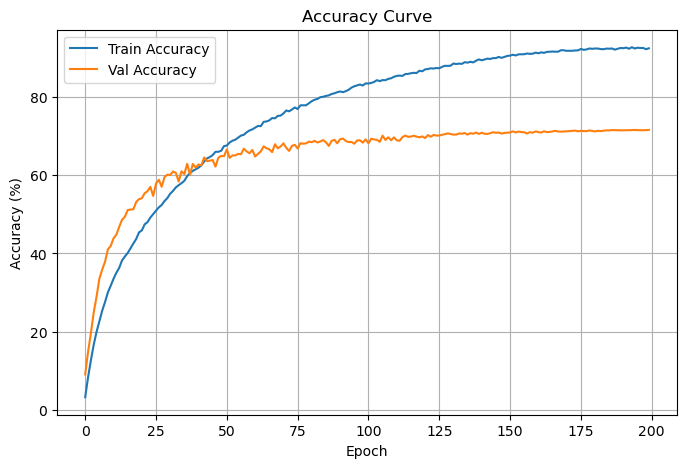

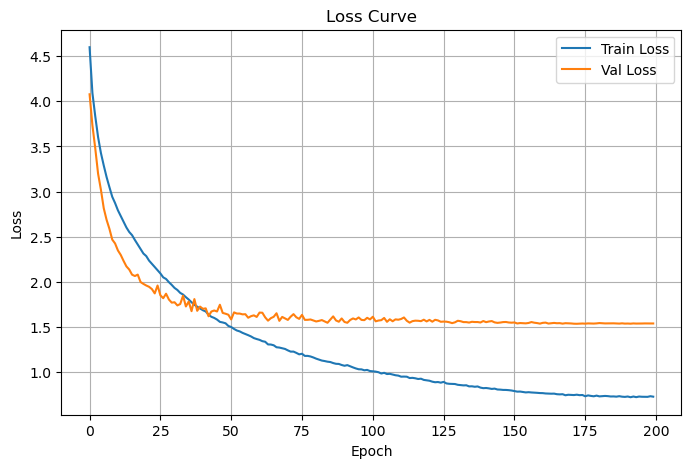

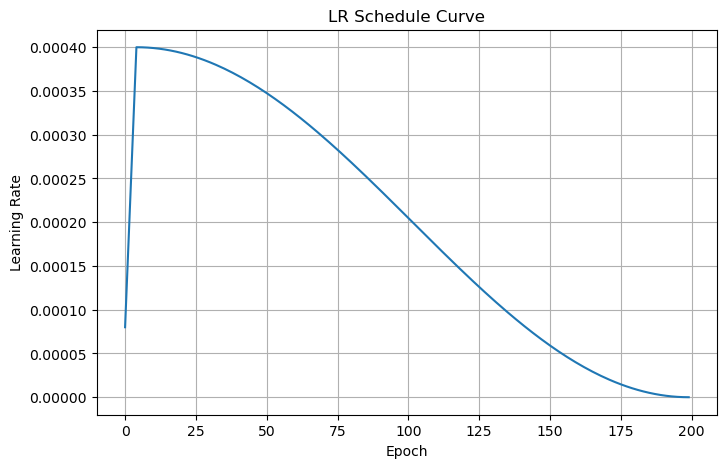

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("Revised_baseline_vit_cifar100_metrics.csv")

# Accuracy Curve
plt.figure(figsize=(8,5))
plt.plot(df["train_acc"], label="Train Accuracy")
plt.plot(df["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("Revised_baseline_accuracy_curve.png", dpi=300)
plt.show()

# Loss Curve
plt.figure(figsize=(8,5))
plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("Revised_baseline_loss_curve.png", dpi=300)
plt.show()

#  Learning Rate Schedule
plt.figure(figsize=(8,5))
plt.plot(df["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("LR Schedule Curve")
plt.grid(True)
plt.savefig("Revised_baseline_lr_curve.png", dpi=300)
plt.show()
